In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '.../data'

Mounted at /content/drive


In [2]:
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import os
from glob import glob
from sklearn import metrics
import numpy as np
import random
from collections import defaultdict

In [3]:
import pandas as pd  # Import pandas for DataFrame operations

def create_age_biased_test_set(df, non_df, bias):
    """
    Creates a biased test set where the proportion of individuals under 41 years old
    (or 41 years and older) is adjusted according to the specified bias, both in
    the 'df' and 'non_df' datasets.

    Parameters:
        df (DataFrame): The first dataset (e.g., primary dataset).
        non_df (DataFrame): The second dataset (e.g., secondary dataset).
        bias (float): The desired proportion of individuals under 41 years old in df.

    Returns:
        DataFrame: A concatenated DataFrame with the adjusted proportions of age
                    groups (<41 and >=41) in both datasets.
    """

    # Calculate the current proportion of individuals under 41 years old in both datasets
    prop1 = sum(df['Age'] < 41) / len(df)
    prop2 = sum(non_df['Age'] < 41) / len(non_df)

    # Adjust the df dataset based on the desired bias level
    if bias <= prop1:
        # If the target bias is lower or equal to the current proportion of individuals under 41,
        # oversample those under 41 to reach the desired bias
        biased_df = pd.concat([
            df,
            df[df['Age'] < 41].sample(
                int((sum(df['Age'] < 41) - len(df) * bias) / (1 - bias)),
                random_state=2022
            )
        ]).drop_duplicates(subset=['Path'], keep=False)
    else:
        # If the target bias is higher than the current proportion of individuals under 41,
        # oversample those 41 and older
        biased_df = pd.concat([
            df,
            df[df['Age'] >= 41].sample(
                int((sum(df['Age'] >= 41) - len(df) * (1 - bias)) / bias),
                random_state=2022
            )
        ]).drop_duplicates(subset=['Path'], keep=False)

    # Calculate the complementary bias for the non_df dataset
    bias2 = 1 - bias

    # Adjust the non_df dataset similarly but based on bias2
    if bias2 <= prop2:
        # If the target bias2 is lower or equal to the current proportion of individuals under 41 in non_df,
        # oversample those under 41
        biased_non_df = pd.concat([
            non_df,
            non_df[non_df['Age'] < 41].sample(
                int((sum(non_df['Age'] < 41) - len(non_df) * bias2) / (1 - bias2)),
                random_state=2022
            )
        ]).drop_duplicates(subset=['Path'], keep=False)
    else:
        # If the target bias2 is higher than the current proportion of individuals under 41 in non_df,
        # oversample those 41 and older
        biased_non_df = pd.concat([
            non_df,
            non_df[non_df['Age'] >= 41].sample(
                int((sum(non_df['Age'] >= 41) - len(non_df) * (1 - bias2)) / bias2),
                random_state=2022
            )
        ]).drop_duplicates(subset=['Path'], keep=False)

    # Return the final concatenated biased dataset
    return pd.concat([biased_df, biased_non_df])


def binarize_by_race(df, race):
    """
    Splits a dataset into two subsets based on a given race category.
    """

    race_df = df[df['Race/Ethnicity'].str.contains(race)]
    non_race_df = df[~df['Race/Ethnicity'].str.contains(race)]


    return race_df, non_race_df


*CheXpert* Trained;
MIMIC Tested

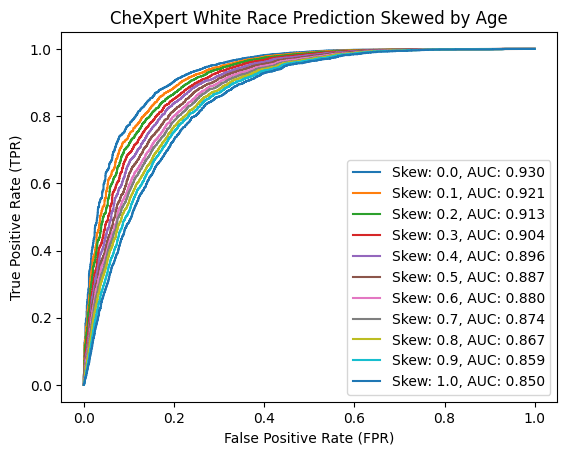

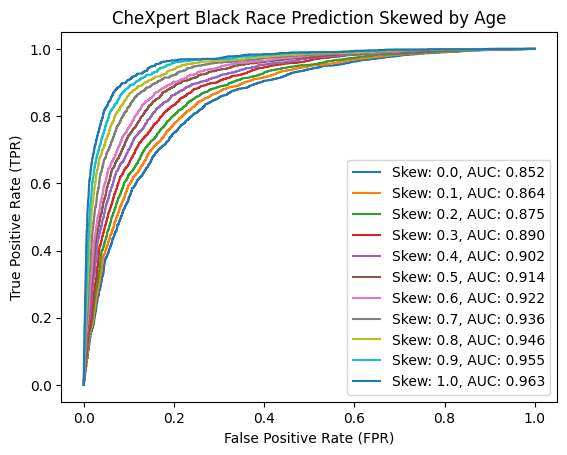

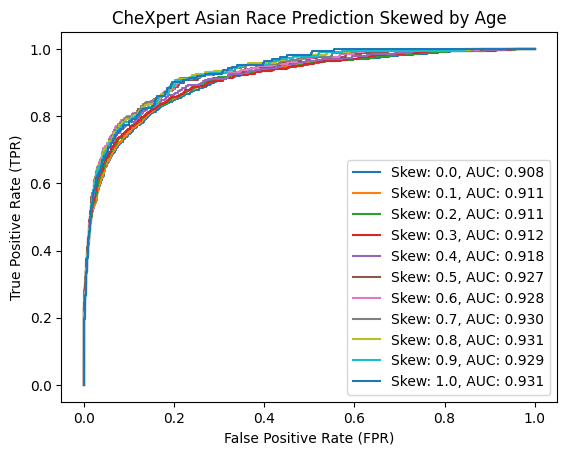

In [4]:
races = ['White', 'Black', 'Asian']
prob_dict = {'White': 2, 'Asian': 0, 'Black': 1}
for race in races:
  df = pd.read_csv(path + '/chexpert_race1_mimic_test.csv')
  df = df.rename(columns={'age': 'Age'})
  df = df[~df['Age'].isna()]
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.rstrip(']')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.lstrip('[')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].apply(np.fromstring, sep=',', dtype = float)
  race_df, nonrace_df = binarize_by_race(df, race)
  #For each bias/skew, created the appropriate skewed dataset and calculate AUCROC
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_age_biased_test_set(race_df, nonrace_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Race/Ethnicity'],y_score = [prob[prob_dict[race]] for prob in biased_test_df['Race/Ethnicity_Probability']], pos_label = race)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('CheXpert ' + race +' Race Prediction Skewed by Age')
  # Show the plot
  plt.show()

CheXpert Trained; CheXpert Tested

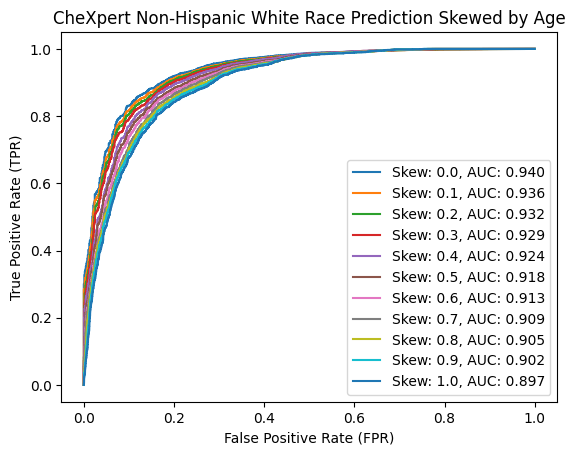

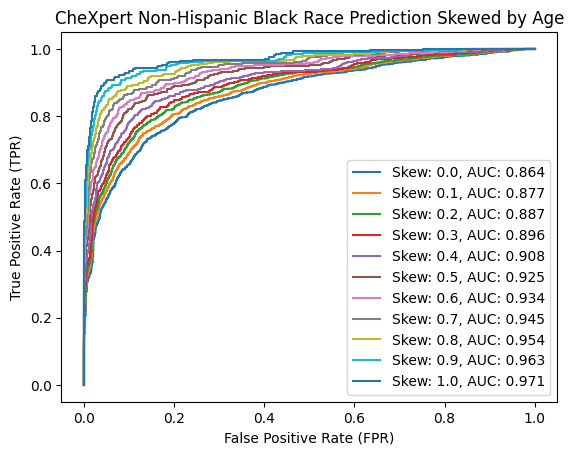

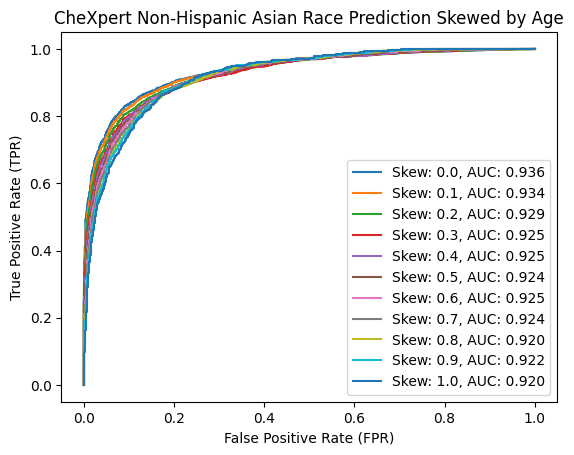

In [5]:
races = ['Non-Hispanic White', 'Non-Hispanic Black', 'Non-Hispanic Asian']
prob_dict = {'Non-Hispanic White': 2, 'Non-Hispanic Asian': 0, 'Non-Hispanic Black': 1}
for race in races:
  df = pd.read_csv(path + '/chexpert_race1_chexpert_test.csv')
  df = df[~df['Age'].isna()]
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.rstrip(']')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.lstrip('[')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].apply(np.fromstring, sep=',', dtype = float)
  race_df, nonrace_df = binarize_by_race(df, race)
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_age_biased_test_set(race_df, nonrace_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Race/Ethnicity'],y_score = [prob[prob_dict[race]] for prob in biased_test_df['Race/Ethnicity_Probability']], pos_label = race)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('CheXpert ' + race +' Race Prediction Skewed by Age')
  # Show the plot
  plt.show()

MIMIC Trained; MIMIC Tested

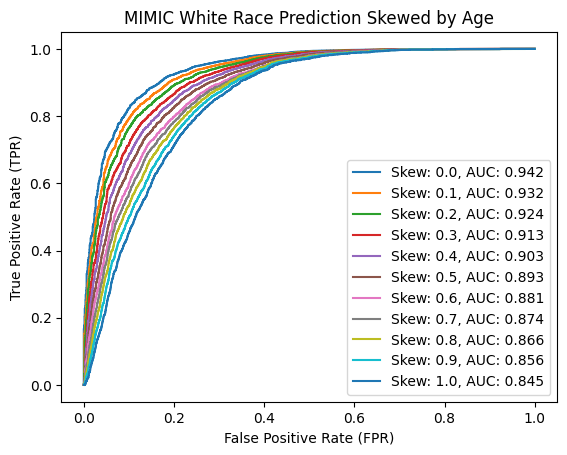

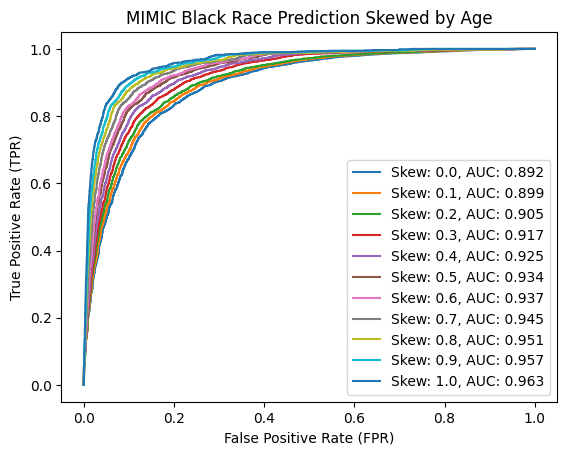

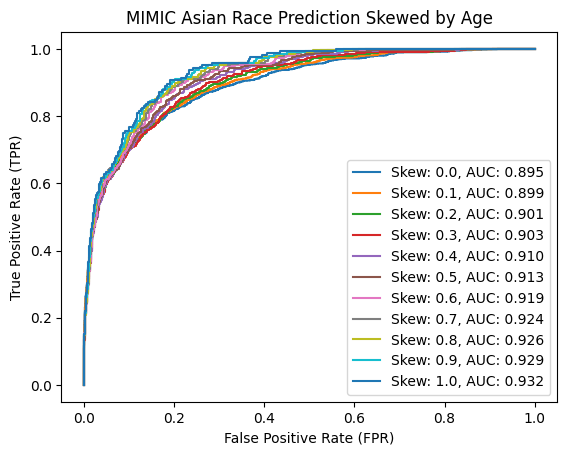

In [6]:
races = ['White', 'Black', 'Asian']
prob_dict = {'White': 4, 'Asian': 0, 'Black': 1}
for race in races:
  df = pd.read_csv(path + '/mimic_race_mimic_test.csv')
  df = df.rename(columns={'age': 'Age'})
  df = df[~df['Age'].isna()]
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.rstrip(']')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.lstrip('[')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].apply(np.fromstring, sep=',', dtype = float)
  race_df, nonrace_df = binarize_by_race(df, race)
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_age_biased_test_set(race_df, nonrace_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Race/Ethnicity'],y_score = [prob[prob_dict[race]] for prob in biased_test_df['Race/Ethnicity_Probability']], pos_label = race)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('MIMIC ' + race +' Race Prediction Skewed by Age')
  # Show the plot
  plt.show()

MIMIC Trained; CheXpert Tested

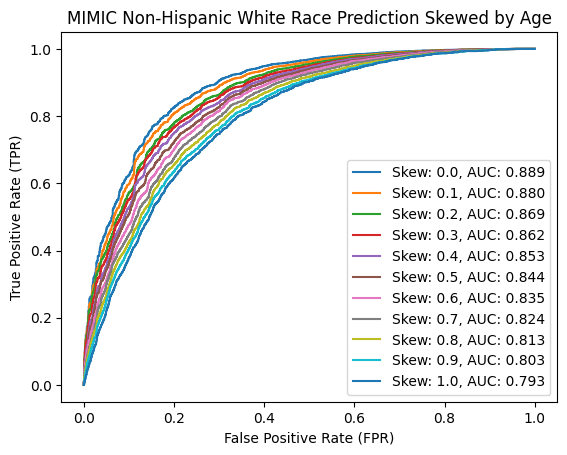

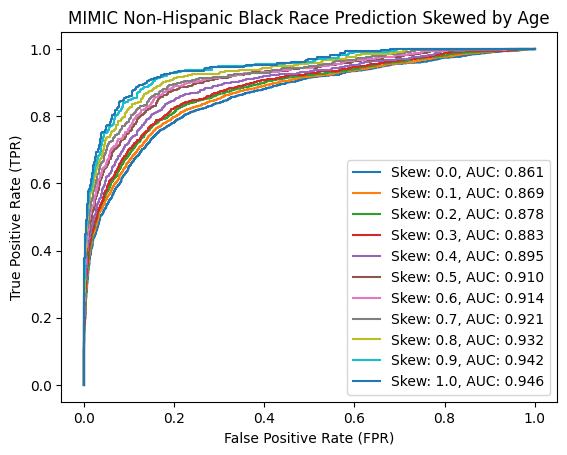

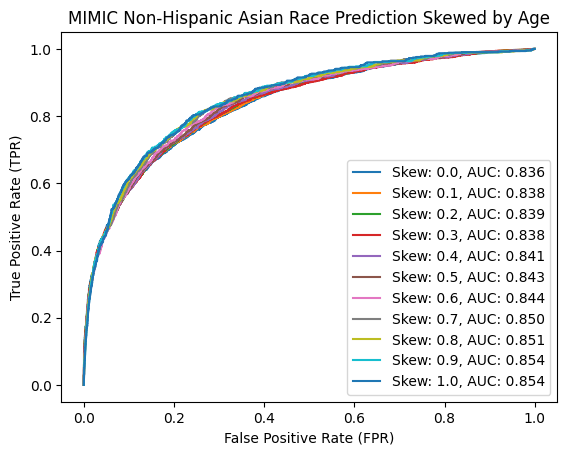

In [7]:
races = ['Non-Hispanic White', 'Non-Hispanic Black', 'Non-Hispanic Asian']
prob_dict = {'Non-Hispanic White': 4, 'Non-Hispanic Asian': 0, 'Non-Hispanic Black': 1}
for race in races:
  df = pd.read_csv(path + '/mimic_race_chexpert_race_v1_test.csv')
  df = df[~df['Age'].isna()]
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.rstrip(']')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.lstrip('[')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].apply(np.fromstring, sep=',', dtype = float)
  race_df, nonrace_df = binarize_by_race(df, race)
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_age_biased_test_set(race_df, nonrace_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Race/Ethnicity'],y_score = [prob[prob_dict[race]] for prob in biased_test_df['Race/Ethnicity_Probability']], pos_label = race)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('MIMIC ' + race +' Race Prediction Skewed by Age')
  # Show the plot
  plt.show()